In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [16]:
from pathlib import Path
import os

iskaggle=os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if iskaggle:
    path=Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path=Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [17]:
df= pd.read_csv(path/'train.csv')

In [18]:
def add_features(df):
    df['LogFare']=np.log1p(df['Fare'])
    df['Deck']=df.Cabin.str[0].map(dict(A='ABC', B='ABC',C='ABC',D='DE',E='DE',F='FG',G='FG'))
    df['Family']=df.SibSp+df.Parch
    df['Alone']=df.Family==0
    df['TicketFreq']=df.groupby('Ticket')['Ticket'].transform('count')
    df['Title']=df.Name.str.split(', ', expand=True)[1].str.split('.',expand=True)[0]
    df['Title']=df.Title.map(dict(Mr='Mr',Miss="Miss",Mrs="Mrs",Master="Master"))
add_features(df)

In [19]:
from fastai.tabular.all import RandomSplitter
splits = RandomSplitter(seed=42)(df)


In [20]:
from fastai.tabular.all import TabularPandas, RandomSplitter, CategoryBlock, Categorify, FillMissing, Normalize
dls=TabularPandas(
    df,splits=splits,
    procs=[Categorify,FillMissing,Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck","Title"],
    cont_names=["Age",'SibSp',"Parch",'LogFare',"Alone","TicketFreq",'Family'],
    y_names='Survived',y_block=CategoryBlock(),
).dataloaders(path='.')

SuggestedLRs(slide=0.015848932787775993, valley=0.002511886414140463)

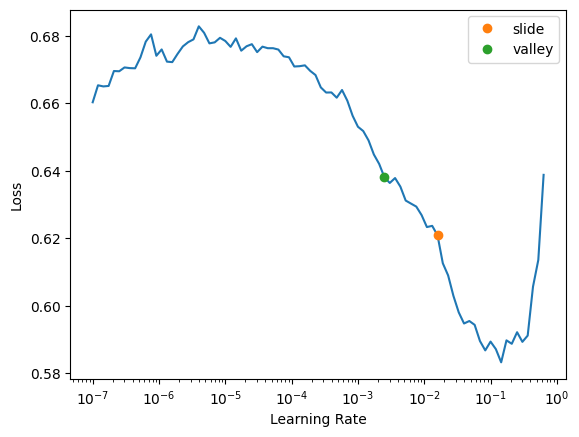

In [24]:
# from fastai.tabular.all import TabularDataLoaders, tabular_learner
# learn.lr_find(suggest_funcs=(slide,valley))
from fastai.callback.schedule import slide, valley
from fastai.tabular.all import TabularDataLoaders, tabular_learner, accuracy

learn = tabular_learner(dls, metrics=accuracy)

learn.lr_find(suggest_funcs=(slide, valley))


In [29]:
learn.fit(16,lr=0.08)

epoch,train_loss,valid_loss,accuracy,time
0,0.326186,0.608644,0.820225,00:00
1,0.359760,0.699378,0.825843,00:00
2,0.366648,0.513031,0.808989,00:00
3,0.363016,0.543296,0.808989,00:00
4,0.366948,0.479412,0.814607,00:00
5,0.360010,0.508517,0.825843,00:00
6,0.352817,0.586347,0.808989,00:00
7,0.345216,0.618355,0.808989,00:00
8,0.343594,0.576564,0.820225,00:00
9,0.335060,0.782670,0.797753,00:00


In [30]:
tst_df=pd.read_csv(path/'test.csv')
tst_df['Fare']=tst_df.Fare.fillna(0)
add_features(tst_df)

In [31]:
tst_dl=learn.dls.test_dl(tst_df)

In [32]:
preds,_ = learn.get_preds(dl=tst_dl)